![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/Spark_NLP_Udemy_MOOC/Open_Source/18.01.ViveknSentiment.ipynb)

# **ViveknSentiment**

This notebook will cover the different parameters and usages of `ViveknSentiment`. This annotator extracts subjective information from documents and uses Naive Bayes classifier for sentiment analysis.

Both `ViveknSentimentApproach` and `ViveknSentimentModel` will be discussed in the notebook.   




**📖 Learning Objectives:**

1. Understand how `ViveknSentiment` algorithm works.

2. Understand how `ViveknSentiment` can be used to train models and also use a trained model to get predictions of the sentiment in a text.

3. Become comfortable using the different parameters of the annotator.


**🔗 Helpful Links:**

- Documentation : [ViveknSentiment](https://nlp.johnsnowlabs.com/docs/en/annotators#viveknsentiment)

- Python Docs : [ViveknSentiment](https://nlp.johnsnowlabs.com/api/python/reference/autosummary/sparknlp/annotator/sentiment/vivekn_sentiment/index.html)

- Scala Docs : [ViveknSentiment](https://nlp.johnsnowlabs.com/api/com/johnsnowlabs/nlp/annotators/sda/vivekn/ViveknSentimentApproach)

- For extended examples of usage, see the [Spark NLP Workshop repository](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/jupyter/training/english/vivekn-sentiment/VivekNarayanSentimentApproach.ipynb).

- Academic Reference Paper: [Fast and accurate sentiment classification using an enhanced Naive Bayes model](https://arxiv.org/abs/1305.6143)

## **📜 Background**

Sentiment analysis involves extraction of subjective information from documents like online reviews to determine the polarity with respect to certain objects. It is useful for identifying trends of public opinion in the social media, for the purpose of marketing and consumer research. It has its uses in getting customer feedback about new product launches, political campaigns and even in financial markets.

ViveknSentiment uses Naive Bayes classifier for sentiment analysis. In statistics, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong independence assumptions between the features.

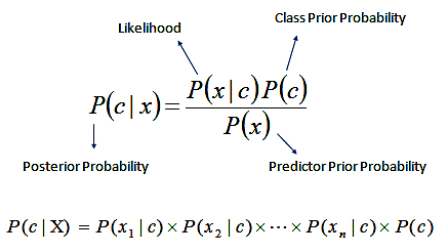

## **🎬 Colab Setup**

In [ ]:
!pip install -q pyspark==3.1.2  spark-nlp==4.2.4

In [ ]:
import sparknlp
import time

from pyspark.ml import PipelineModel
from sparknlp.annotator import *
from sparknlp.base import *

from pyspark.sql.functions import when, col, array_contains

spark = sparknlp.start()

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 4.2.4
Apache Spark version: 3.1.2


## **🖨️ Input/Output Annotation Types**

- Input: `TOKEN`, `DOCUMENT`

- Output: `SENTIMENT`

## **🔎 Parameters**



- `setFeatureLimit`: (int) Content feature limit, to boost performance in very dirty text (Default: disabled with -1).

- `setImportantFeatureRatio`: (DoubleParam) Proportion of feature content to be considered relevant (Default: 0.5).

- `setUnimportantFeatureStep`: (DoubleParam) Proportion to lookahead in unimportant features (Default: 0.025).

- `setPruneCorpus`: (int) Removes unfrequent scenarios from scope. The higher the better performance (Default: 1).

- `setSentimentCol`: (str) Column with the sentiment result of every row. Must be ‘positive’ or ‘negative’.




## **💻 ViveknSentimentApproach Pipeline**



In order to show the capacity of the [ViveknSentimentApproach](https://nlp.johnsnowlabs.com/docs/en/annotators#viveknsentiment) annotator in model training, we train a model with just **6 sentences** and then use this trained model to get predictions.

In [ ]:
document = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

token = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normal")

vivekn = ViveknSentimentApproach() \
    .setInputCols(["document", "normal"]) \
    .setSentimentCol("train_sentiment") \
    .setOutputCol("sentiment")

finisher = Finisher() \
    .setInputCols(["sentiment"]) \
    .setOutputCols("final_sentiment")

pipeline = Pipeline().setStages([document, token, normalizer, vivekn, finisher])


In [ ]:
training = spark.createDataFrame([
    ("I really liked this movie!", "positive"),
    ("The cast was horrible", "negative"),
    ("Never going to watch this again or recommend it to anyone", "negative"),
    ("It's a waste of time", "negative"),
    ("I loved the protagonist", "positive"),
    ("The music was really really good", "positive")
]).toDF("text", "train_sentiment")

In [ ]:
pipelineModel = pipeline.fit(training)

In [ ]:
data = spark.createDataFrame([
    ["I recommend this movie"],
    ["Dont waste your time!!!"]
]).toDF("text")

In [ ]:
result = pipelineModel.transform(data)

In [ ]:
result.select("text", "final_sentiment").show(truncate=False)

+-----------------------+---------------+
|text                   |final_sentiment|
+-----------------------+---------------+
|I recommend this movie |[positive]     |
|Dont waste your time!!!|[negative]     |
+-----------------------+---------------+




In this example, instead of just 6 sentences, we train the model with a dataset of **1000 texts** and also use [NorvigSweeting Spellchecker](https://nlp.johnsnowlabs.com/docs/en/annotators#norvigsweeting-spellchecker) to search for misspellings.

In [ ]:
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/spell/words.txt -P /tmp
!rm -rf /tmp/sentiment.parquet
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sentiment.parquet.zip -P /tmp
! unzip /tmp/sentiment.parquet.zip -d /tmp/

In [ ]:
data = spark. \
        read. \
        parquet("/tmp/sentiment.parquet"). \
        withColumn("sentiment_label", when(col("sentiment") == 0, "negative").otherwise("positive")). \
        limit(1000).cache()
data.select('text', 'sentiment_label').show(10, truncate = 120)

+------------------------------------------------------------------------------------------------------------------------+---------------+
|                                                                                                                    text|sentiment_label|
+------------------------------------------------------------------------------------------------------------------------+---------------+
|                                                                                is so sad for my APL friend.............|       negative|
|                                                                                        I missed the New Moon trailer...|       negative|
|                                                                                                 omg its already 7:30 :O|       positive|
|          .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put...|       negative|
|                          

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normal")

spell_checker = NorvigSweetingApproach() \
     .setInputCols(["normal"]) \
     .setOutputCol("spell") \
     .setDictionary("/tmp/words.txt")

sentiment_detector = ViveknSentimentApproach() \
    .setInputCols(["spell", "sentence"]) \
    .setSentimentCol("sentiment_label") \
    .setOutputCol("sentiment")\

finisher = Finisher() \
    .setInputCols(["sentiment"]) \
    .setIncludeMetadata(False)

pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer,
    normalizer,
    spell_checker,
    sentiment_detector,
    finisher
])

sentiment_data = pipeline.fit(data).transform(data)

In [ ]:
sentiment_data.show(10,truncate = 100)

+------+----------------------------------------------------------------------------------------------------+---------------+----------------------------------------+
|itemid|                                                                                                text|sentiment_label|                      finished_sentiment|
+------+----------------------------------------------------------------------------------------------------+---------------+----------------------------------------+
|     1|                                                            is so sad for my APL friend.............|       negative|                              [negative]|
|     2|                                                                    I missed the New Moon trailer...|       negative|                              [negative]|
|     3|                                                                             omg its already 7:30 :O|       positive|                              [positive]

## `setFeatureLimit` & `setSentimentCol`

`setFeatureLimit` was set to **10** (default value: -1) - Content feature limit, to boost performance in very dirty text;    

`setSentimentCol` is already set to 'sentiment_label', which is the column name of the dataset.


In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normal")

spell_checker = NorvigSweetingApproach() \
     .setInputCols(["normal"]) \
     .setOutputCol("spell") \
     .setDictionary("/tmp/words.txt")

sentiment_detector = ViveknSentimentApproach() \
    .setInputCols(["spell", "sentence"]) \
    .setSentimentCol("sentiment_label") \
    .setOutputCol("sentiment")\
    .setFeatureLimit(10)

finisher = Finisher() \
    .setInputCols(["sentiment"]) \
    .setIncludeMetadata(False)

pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer,
    normalizer,
    spell_checker,
    sentiment_detector,
    finisher
])

sentiment_data = pipeline.fit(data).transform(data)

In [ ]:
sentiment_data.show(10,truncate = 100)

+------+----------------------------------------------------------------------------------------------------+---------------+----------------------------------------+
|itemid|                                                                                                text|sentiment_label|                      finished_sentiment|
+------+----------------------------------------------------------------------------------------------------+---------------+----------------------------------------+
|     1|                                                            is so sad for my APL friend.............|       negative|                              [negative]|
|     2|                                                                    I missed the New Moon trailer...|       negative|                              [negative]|
|     3|                                                                             omg its already 7:30 :O|       positive|                              [positive]

Changing the `setFeatureLimit` parameter caused a change in the sentiment prediction of item # 8.

## `setImportantFeatureRatio`

`setImportantFeatureRatio` was set to **25** (default value: 0.5) - proportion of feature content to be considered relevant .



In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normal")

spell_checker = NorvigSweetingApproach() \
     .setInputCols(["normal"]) \
     .setOutputCol("spell") \
     .setDictionary("/tmp/words.txt")

sentiment_detector = ViveknSentimentApproach() \
    .setInputCols(["spell", "sentence"]) \
    .setSentimentCol("sentiment_label") \
    .setOutputCol("sentiment")\
    .setImportantFeatureRatio(25)\
    
    
finisher = Finisher() \
    .setInputCols(["sentiment"]) \
    .setIncludeMetadata(False)

pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer,
    normalizer,
    spell_checker,
    sentiment_detector,
    finisher
])

sentiment_data = pipeline.fit(data).transform(data)

In [ ]:
sentiment_data.show(10,truncate = 100)

+------+----------------------------------------------------------------------------------------------------+---------------+----------------------------------------+
|itemid|                                                                                                text|sentiment_label|                      finished_sentiment|
+------+----------------------------------------------------------------------------------------------------+---------------+----------------------------------------+
|     1|                                                            is so sad for my APL friend.............|       negative|                              [negative]|
|     2|                                                                    I missed the New Moon trailer...|       negative|                              [negative]|
|     3|                                                                             omg its already 7:30 :O|       positive|                              [positive]

## `setUnimportantFeatureStep`

`setUnimportantFeatureStep` was set to **2.5** (default value: 0.025) - proportion to lookahead in unimportant features.

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normal")

spell_checker = NorvigSweetingApproach() \
     .setInputCols(["normal"]) \
     .setOutputCol("spell") \
     .setDictionary("/tmp/words.txt")

sentiment_detector = ViveknSentimentApproach() \
    .setInputCols(["spell", "sentence"]) \
    .setSentimentCol("sentiment_label") \
    .setOutputCol("sentiment")\
    .setUnimportantFeatureStep(2.5)

finisher = Finisher() \
    .setInputCols(["sentiment"]) \
    .setIncludeMetadata(False)

pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer,
    normalizer,
    spell_checker,
    sentiment_detector,
    finisher
])

sentiment_data = pipeline.fit(data).transform(data)

In [ ]:
sentiment_data.show(10,truncate = 100)

+------+----------------------------------------------------------------------------------------------------+---------------+----------------------------------------+
|itemid|                                                                                                text|sentiment_label|                      finished_sentiment|
+------+----------------------------------------------------------------------------------------------------+---------------+----------------------------------------+
|     1|                                                            is so sad for my APL friend.............|       negative|                              [negative]|
|     2|                                                                    I missed the New Moon trailer...|       negative|                              [negative]|
|     3|                                                                             omg its already 7:30 :O|       positive|                              [positive]

## **💻 ViveknSentimentModel Pipeline**



Instead of training a model, we can use a pretrained model from the [Models' Hub](https://nlp.johnsnowlabs.com/2021/11/22/sentiment_vivekn_en.html) to predict the sentiment in a text.

In [ ]:
document = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

token = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normal")

vivekn = ViveknSentimentModel.pretrained('sentiment_vivekn') \
    .setInputCols(["document", "normal"]) \
    .setOutputCol("result_sentiment")\
    .setFeatureLimit(4)

finisher = Finisher() \
    .setInputCols(["result_sentiment"]) \
    .setOutputCols("final_sentiment")

pipeline_M = Pipeline().setStages([document, token, normalizer, vivekn, finisher])

sentiment_vivekn download started this may take some time.
Approximate size to download 873.6 KB
[OK!]


In [ ]:
pipeline_Model = pipeline_M.fit(data)
result_M = pipeline_Model.transform(data)

In [ ]:
result_M.select('text', "sentiment_label", "final_sentiment").show(10, truncate=120)

+------------------------------------------------------------------------------------------------------------------------+---------------+---------------+
|                                                                                                                    text|sentiment_label|final_sentiment|
+------------------------------------------------------------------------------------------------------------------------+---------------+---------------+
|                                                                                is so sad for my APL friend.............|       negative|     [positive]|
|                                                                                        I missed the New Moon trailer...|       negative|     [negative]|
|                                                                                                 omg its already 7:30 :O|       positive|     [positive]|
|          .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist

The sentiment predictions provided by the pretrained model were quite different from the model that we trained above. More than half the predicted sentiments were different.